In [1]:
import fenics as fn
import matplotlib.pyplot as plt
from dolfin_utils.meshconvert import meshconvert
import os
from subprocess import call

import numpy as np
import jax
import jax.numpy as jnp
from jax.example_libraries import stax, optimizers
import matplotlib.pyplot as plt
import pinns 
import datetime
import jax.scipy.optimize
import jax.flatten_util
import scipy
import scipy.optimize
import chaospy as cp

In [2]:
def curl2D(v):
    return fn.as_vector((v.dx(1),-v.dx(0)))

class FEM():
            
    def __init__(self,J0=1000.0,mu0=1.0,mur=10.0, k1=0.001, k2=1.65, k3 = 0.5, meshsize = 0.001, params = [0,0,0,0,0,0],  verb = False):

        # fn.set_log_active(False)
        path='./quad/'
        
        with open(path + 'quad_param.geo', 'r') as file:
            data = file.read()
            
        s = "meshsize=%.18f;\np0 = %.18f;\np1 = %.18f;\np2 = %.18f;\n"%(meshsize,params[0],params[1],params[2])
        
        s = s + data
        
        with  open(path+"tmp.geo", "w") as file:
            file.write(s)
            file.close()
        if verb: print('geo file created',flush = True)
        
        if verb:
            os.system('gmsh %stmp.geo -nt 20 -3 -o %stmp.msh -format msh2 '%(path,path))
        else:
            os.system('gmsh %stmp.geo -nt 20 -3 -o %stmp.msh -format msh2 >/dev/null 2>&1'%(path,path))
        if verb: print('mesh file created',flush=True)

        if verb:
            os.system('dolfin-convert %stmp.msh %stmp.xml'%(path,path))
        else:
            os.system('dolfin-convert %stmp.msh %stmp.xml >/dev/null 2>&1'%(path,path))
        
        if verb: print('mesh file converted in fenics format',flush=True) 

        mesh = fn.Mesh(path+'tmp.xml')
        domains = fn.MeshFunction("size_t", mesh, path+'tmp_physical_region.xml')
        boundaries = fn.MeshFunction('size_t', mesh, path+'tmp_facet_region.xml')

        self.mesh = mesh
        ncells = [  mesh.num_vertices(), mesh.num_edges(), mesh.num_faces(), mesh.num_facets(), mesh.num_cells() ]
        
        def nu_lin(az):
            return 1/(mu0*mur)

        def nonlin_nu(az):
            tmp =  (k1*(1+0.1*params[3]))*fn.exp((k2*(1+0.1*params[4]))*fn.dot(az.dx(1),az.dx(1)))+(k3*(1+0.1*params[5]))
            return tmp
        
        def nu_Bauer(B):
            x = fn.dot(B,B)
            return (k1*(1+0.1*params[3]))*fn.exp((k2*(1+0.1*params[4]))*x)+(k3*(1+0.1*params[5]))
        
        # Coil
        def setup_coil(mesh,subdomains):
            DG = fn.FunctionSpace(mesh,"DG",0)
            J = fn.Function(DG)
            idx = []
            for cell_no in range(len(subdomains.array())):
                subdomain_no = subdomains.array()[cell_no]
                if subdomain_no == 3:
                    idx.append(cell_no)
            J.vector()[:] = 0
            J.vector()[idx] = J0
            return J
        
    
        
        """ define function space and boundary conditions"""
        
        CG = fn.FunctionSpace(mesh, 'CG', 1) # Continuous Galerkin
        
        # Define boundary condition
        bc = fn.DirichletBC(CG, fn.Constant(0.0), boundaries,16)
        
        # Define subdomain markers and integration measure
        dx = fn.Measure('dx', domain=mesh, subdomain_data=domains)
        
        J = setup_coil(mesh, domains)
        
        class Nu(fn.UserExpression): # UserExpression instead of Expression
            def __init__(self, markers, **kwargs):
                super().__init__(**kwargs) # This part is new!
                self.markers = markers
            def eval_cell(self, values, x, cell):
                if self.markers[cell.index] == 1:
                    values[0] = 0.0   # iron
                elif self.markers[cell.index] == 2:
                    values[0] = 1/mu0      # air
                elif self.markers[cell.index] == 3:
                    values[0] = 1/mu0      # air
                else:
                    print('no such domain',self.markers[cell.index] )
                    
        nus = Nu(domains, degree=1)
        
        
        """ weak formulation """
        
        az  = fn.Function(CG)
        u  = fn.Function(CG)
        v  = fn.TestFunction(CG)
        #az = Function(CG)
        #a  = (1/mu)*dot(grad(az), grad(v))*dx
        a = fn.inner(nus*curl2D(u), curl2D(v))*dx + fn.inner(nu_Bauer(curl2D(u))*curl2D(u),curl2D(v))*dx(1)
        L  = J*v*dx(3)
        
        F = a - L
        # solve variational problem
        fn.solve(F == 0, u, bc)
        az = u
        self.az = az
        # function space for H- and B- field allocated on faces of elements
        W = fn.VectorFunctionSpace(mesh, fn.FiniteElement("DP", fn.triangle, 0),1)
        B = fn.project(curl2D(az), W)
        H = None# project((1/mu)*curl(az), W)
        self.B = B
        self.H = H
        self.surface_cu = fn.assemble(fn.Constant(1.0)*dx(3))
    
    def call_A(self,x_eval,y_eval):
        
        
        Afem = 0 * x_eval
        for i in range(x_eval.size):
            try:
                Afem[i] = self.az(x_eval[i],y_eval[i])
            except:
                Afem[i] = np.nan
        return Afem
    
    def call_B(self,x_eval,y_eval):
        
        
        Bfem = []
        for i in range(x_eval.size):
            try:
                Bfem.append(self.B(x_eval[i],y_eval[i]))
            except:
                Bfem.append([ np.nan , np.nan])
        return np.array(Bfem)
    
    def call_H(self,x_eval,y_eval):
        Hfem = []
        for i in range(x_eval.size):
            try:
                Hfem.append(self.H(x_eval[i],y_eval[i]))
            except:
                Hfem.append([ np.nan , np.nan])
        return np.array(Hfem)

In [3]:
from jax.config import config
config.update("jax_enable_x64", True)
rnd_key = jax.random.PRNGKey(1234)

In [4]:

def create_geometry(key, scale = 1):
    scale = scale
    Nt = 24                                                                
    lz = 40e-3                                                             
    Do = 72e-3                                                            
    Di = 51e-3                                                            
    hi = 13e-3                                                             
    bli = 3e-3                                                             
    Dc = 3.27640e-2                                                           
    hc = 7.55176e-3                                                           
    ri = 20e-3                                                           
    ra = 18e-3                                                           
    blc = hi-hc      
    var = 0.001                                                     
    # rm = (Dc*Dc+hc*hc-ri*ri)/(Dc*np.sqrt(2)+hc*np.sqrt(2)-2*ri)                 
    # R = rm-ri
    # O = np.array([rm/np.sqrt(2),rm/np.sqrt(2)])
    # alpha1 = -np.pi*3/4       
    # alpha2 = np.math.asin((hc-rm/np.sqrt(2))/R)
    # alpha = np.abs(alpha2-alpha1)
    
    # A = np.array([[O[0] - ri/np.sqrt(2), O[1] - ri/np.sqrt(2)], [O[0] - Dc, O[1] - hc]])
    # b = np.array([[A[0,0]*ri/np.sqrt(2)+A[0,1]*ri/np.sqrt(2)],[A[1,0]*Dc+A[1,1]*hc]])
    # C = np.linalg.solve(A,b)

    
     
    def knots_func1(ps):
        ps = ps*var
        rm = ((Dc+ps[1])**2+(hc+ps[2])**2-(ri+ps[0])**2)/((Dc+ps[1])*np.sqrt(2)+(hc+ps[2])*np.sqrt(2)-2*(ri+ps[0]))                  
        R = rm-(ri+ps[0])
        O = jnp.array([rm/np.sqrt(2),rm/np.sqrt(2)])
        
        A = jnp.array([[O[0] - (ri+ps[0])/np.sqrt(2), O[1] - (ri+ps[0])/np.sqrt(2)], [O[0] - (Dc+ps[1]), O[1] - (hc+ps[2])]])
        b = jnp.array([[A[0,0]*(ri+ps[0])/np.sqrt(2)+A[0,1]*(ri+ps[0])/np.sqrt(2)],[A[1,0]*(Dc+ps[1])+A[1,1]*(hc+ps[2])]])
        C = jnp.linalg.solve(A,b)
        knots1 = jnp.array([[Do,Do * np.tan(np.pi/8)],[Do/np.sqrt(2),Do/np.sqrt(2)],[rm/np.sqrt(2),rm/np.sqrt(2)],[(ri+ps[0])/np.sqrt(2),(ri+ps[0])/np.sqrt(2)]])
        #knots2 = np.array([[Dc,hc],[Dc+blc,hi],[Di-bli,hi],[Di,hi-bli],[Di,0]])
        knots2 = jnp.array([[Di,hi-bli],[Di-bli,hi],[Dc+ps[1]+blc,hi],[Dc+ps[1],hc+ps[2]]])
        knots3 = jnp.array([[0.5*(knots1[0,0]+knots2[0,0]), 0.5*(knots1[0,1]+knots2[0,1])], [0.5*(knots1[1,0]+knots2[1,0]), 0.5*(knots1[1,1]+knots2[1,1])], [0.5*(knots1[2,0]+knots2[2,0]), 0.5*(knots1[2,1]+knots2[2,1])], [C[0,0], C[1,0]]]) 
        knots = jnp.concatenate((knots1[None,...],knots3[None,...],knots2[None,...]),0)
        return knots
    
    def weights_func1(ps):
        ps = ps*var
        rm = ((Dc+ps[1])**2+(hc+ps[2])**2-(ri+ps[0])**2)/((Dc+ps[1])*np.sqrt(2)+(hc+ps[2])*np.sqrt(2)-2*(ri+ps[0]))                 
        R = rm-(ri+ps[0])
        alpha1 = -np.pi*3/4       
        alpha2 = jax.lax.asin(((hc+ps[2])-rm/np.sqrt(2))/R)
        alpha = jnp.abs(alpha2-alpha1)
        weights = jnp.array([[1.0,1.0,1.0,1.0], [1.0,1.0,1.0,jnp.sin((np.pi-alpha)/2)], [1.0,1.0,1.0,1.0]])
        return weights
    
    basis2 = pinns.bspline.BSplineBasisJAX(np.array([-1,-0.33,0.33,1]),1)
    basis1 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),2)

    geom1 = pinns.geometry.PatchNURBSParam([basis1, basis2], knots_func1, weights_func1, 6, 2, key)
   
    # copper part
    
    def knots_func3(ps):
        ps = ps*var
        knots = jnp.array([ [ [(Dc+ps[1]),0],[(Dc+ps[1])+blc,0],[Di-bli,0],[Di,0] ] , [[(Dc+ps[1]),(hc+ps[2])],[(Dc+ps[1])+blc,hi],[Di-bli,hi],[Di,hi-bli]] ]) 
        knots = knots[:,::-1,:]
        return knots
    
    weights_func3 = lambda ps: jnp.ones((2,4))
    
    basis1 = pinns.bspline.BSplineBasisJAX(np.linspace(-1,1,2),1)
    basis2 = pinns.bspline.BSplineBasisJAX(np.array([-1,-0.33,0.33,1]),1)

    geom3 = pinns.geometry.PatchNURBSParam([basis1, basis2], knots_func3, weights_func3, 6, 2, key)
   
    # air gap
    
    def knots_func2(ps):
        ps = ps*var
        rm = ((Dc+ps[1])**2+(hc+ps[2])**2-(ri+ps[0])**2)/((Dc+ps[1])*np.sqrt(2)+(hc+ps[2])*np.sqrt(2)-2*(ri+ps[0]))                  
        R = rm-(ri+ps[0])
        O = jnp.array([rm/np.sqrt(2),rm/np.sqrt(2)])
        
        A = jnp.array([[O[0] - (ri+ps[0])/np.sqrt(2), O[1] - (ri+ps[0])/np.sqrt(2)], [O[0] - (Dc+ps[1]), O[1] - (hc+ps[2])]])
        b = jnp.array([[A[0,0]*(ri+ps[0])/np.sqrt(2)+A[0,1]*(ri+ps[0])/np.sqrt(2)],[A[1,0]*(Dc+ps[1])+A[1,1]*(hc+ps[2])]])
        C = jnp.linalg.solve(A,b)
        knots = jnp.array([ [ [0,0] , [(Dc+ps[1])/2,0] , [(Dc+ps[1]),0] ] , [ [(ri+ps[0])/np.sqrt(2),(ri+ps[0])/np.sqrt(2)] , [C[0,0],C[1,0]] , [(Dc+ps[1]),(hc+ps[2])] ]])
        return knots
    
    def weights_func2(ps):
        ps = ps*var
        rm = ((Dc+ps[1])**2+(hc+ps[2])**2-(ri+ps[0])**2)/((Dc+ps[1])*np.sqrt(2)+(hc+ps[2])*np.sqrt(2)-2*(ri+ps[0]))                 
        R = rm-(ri+ps[0])
        alpha1 = -np.pi*3/4       
        alpha2 = jax.lax.asin(((hc+ps[2])-rm/np.sqrt(2))/R)
        alpha = jnp.abs(alpha2-alpha1)
        weights = jnp.array([[1.0,1.0,1.0],[1.0,jnp.sin((np.pi-alpha)/2),1.0]])
        return weights
    
    basis1 = pinns.bspline.BSplineBasisJAX(np.linspace(-1,1,2),1)
    basis2 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),2)
    
    
    geom2 = pinns.geometry.PatchNURBSParam([basis1, basis2], knots_func2, weights_func2, 6, 2, key)

    # iron 2
    def knots_func4(ps):
        ps = ps*var
        knots1 = jnp.array([[Do,0],[Do,Do * np.tan(np.pi/8)]])
        knots2 = jnp.array([[Di,0],[Di,hi-bli]])
        knots3 = (knots1+knots2)/2
        knots = jnp.concatenate((knots1[None,...],knots3[None,...],knots2[None,...]),0)
        return knots
    
    weights_func4  = lambda ps: jnp.ones((3,2))

    basis2 = pinns.bspline.BSplineBasisJAX(np.linspace(-1,1,2),1)
    basis1 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),2)

    geom4 = pinns.geometry.PatchNURBSParam([basis1, basis2], knots_func4, weights_func4, 6, 2, key)
    
    surface_cu = lambda ps: hi*(Di-bli-(Dc+ps[...,1]*var+blc))+0.5*bli*(hi+hi-bli)+0.5*blc*(hi+hc+ps[...,2]*var)
    return  geom1, geom2, geom3, geom4, surface_cu
    

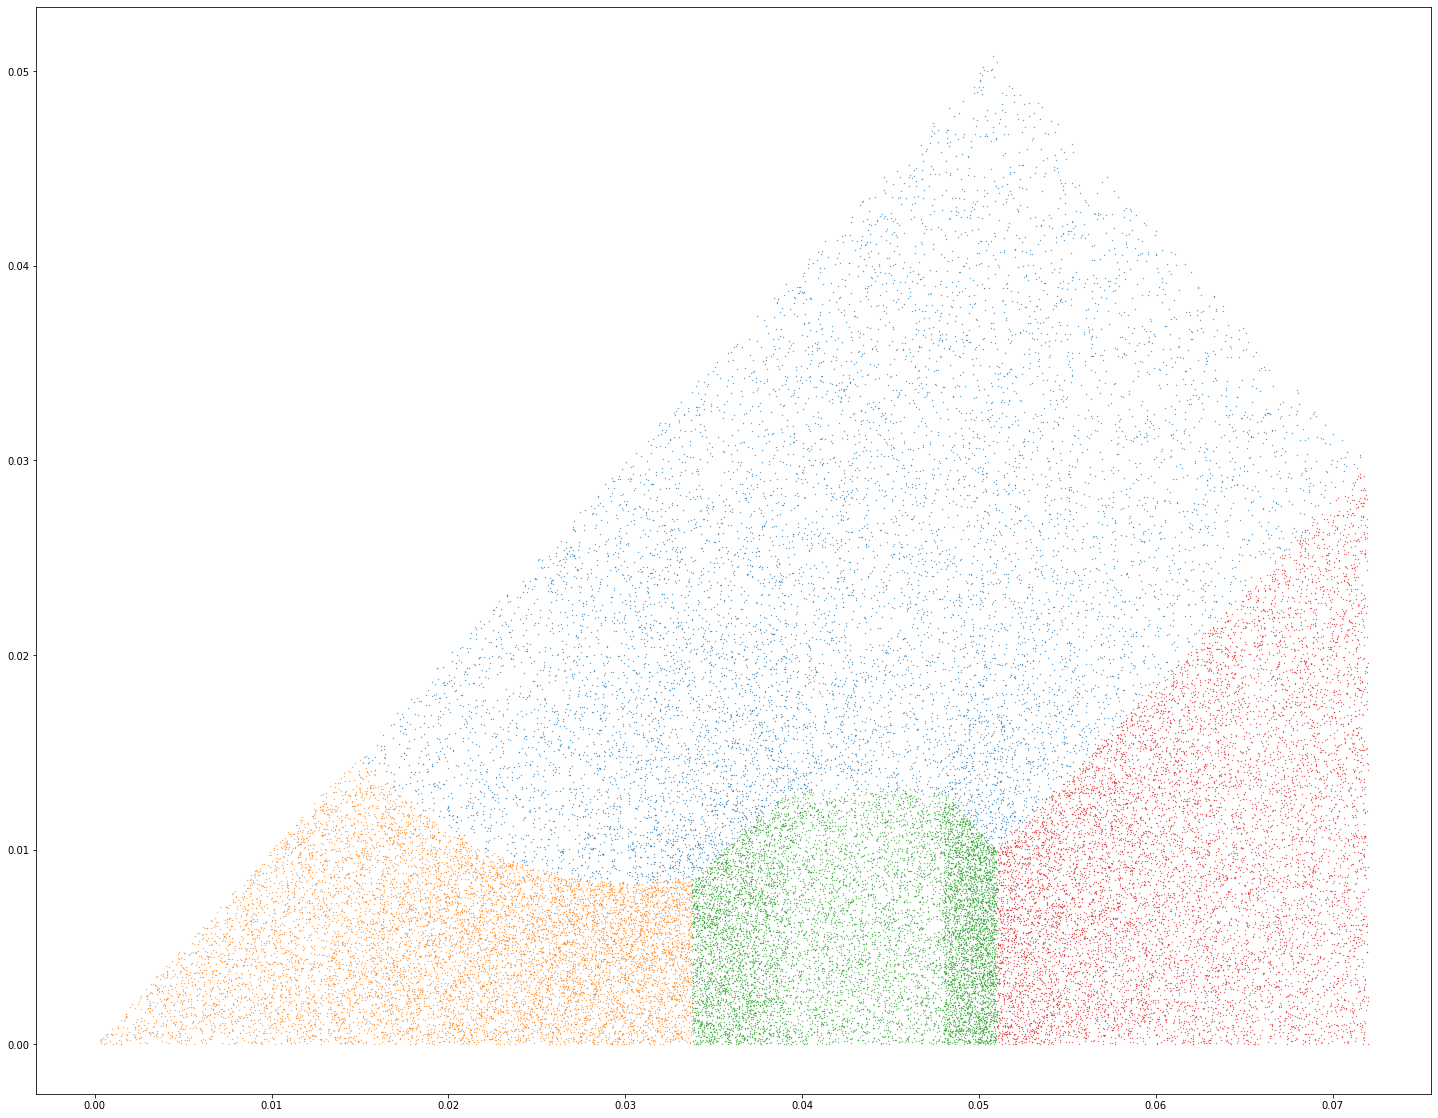

In [5]:
geom1, geom2, geom3, geom4, surface_cu = create_geometry(rnd_key)

pts = geom1(np.random.rand(10000,2)*2-1,np.ones((10000,6)))

plt.figure(figsize=(25,20))
plt.scatter(pts[:,0], pts[:,1], s = 0.1)

pts = geom2(np.random.rand(10000,2)*2-1,np.ones((10000,6)))
plt.scatter(pts[:,0],pts[:,1], s = 0.1)

pts = geom3(np.random.rand(10000,2)*2-1,np.ones((10000,6)))
plt.scatter(pts[:,0],pts[:,1], s = 0.1)

pts = geom4(np.random.rand(10000,2)*2-1,np.ones((10000,6)))
plt.scatter(pts[:,0],pts[:,1], s = 0.1)
plt.show()





In [6]:
def interface_function2d(nd, endpositive, endzero, nn):

    faux = lambda x: ((x-endzero)**1/(endpositive-endzero)**1)
    if nd == 0:
        fret = lambda ws, x, *params: (nn(ws, x[...,1][...,None], *params).flatten()*faux(x[...,0]))[...,None]
    else:
        fret = lambda ws, x, *params: (nn(ws, x[...,0][...,None], *params).flatten()*faux(x[...,1]))[...,None]
    return fret

def jump_function2d(nd, pos_y, nn):

    faux = lambda x: jnp.exp(-2.0*jnp.abs(x-pos_y))
    if nd == 1:
        fret = lambda ws, x, *params: (nn(ws, x[...,1][...,None], *params).flatten()*faux(x[...,0]))[...,None]
    else:
        fret = lambda ws, x, *params: (nn(ws, x[...,0][...,None], *params).flatten()*faux(x[...,1]))[...,None]
    return fret

# def ExpHat(hidden_size, out_dim, W_init=glorot_normal(), b_init=normal()):
#   """Layer constructor function for a dense (fully-connected) layer."""
#   def init_fun(rng, input_shape):
#     output_shape = input_shape[:-1] + (out_dim,)
#     k1, k2 = random.split(rng)
#     W, b = W_init(k1, (input_shape[-1], out_dim)), b_init(k2, (out_dim,))
#     return output_shape, (W, b)
#   def apply_fun(params, inputs, **kwargs):
#     b, b = params
#     return jnp.dot(inputs, W) + b
#   return init_fun, apply_fun

def ConcatLayer(axis=-1):
  """Layer construction function for a fan-in concatenation layer."""
  def init_fun(rng, input_shape):
    ax = axis % len(input_shape[0])
    concat_size = sum(shape[ax] for shape in input_shape)
    out_shape = input_shape[0][:ax] + (concat_size,) + input_shape[0][ax+1:]
    return out_shape, ()
  def apply_fun(params, *inputs):
    print(inputs)
    return jnp.concatenate(inputs, axis)
  return init_fun, apply_fun

def ExpHat(x, scale = 0.5):
    return jnp.exp(-jnp.abs(x)/scale)

class Model(pinns.PINN):
    def __init__(self, rand_key):
        super().__init__()
        self.key = rand_key

        N = [32,32]
        nl = 20
        NP = 6
        
        acti = stax.Tanh
        acti =  stax.elementwise(lambda x: jax.nn.leaky_relu(x)**2)
        # acti1 = stax.elementwise(lambda x: jax.nn.leaky_relu(x+1)**2)
        # acti2 = stax.elementwise(lambda x: jax.nn.leaky_relu(x+0.33)**2)
        # acti3 = stax.elementwise(lambda x: jax.nn.leaky_relu(x-0.33)**2)
        # acti4 = stax.elementwise(lambda x: jnp.exp(-1.0*jnp.abs(x)))
        
        initial = jax.nn.initializers.normal()

        block_first = stax.serial(stax.FanInConcat(),stax.Dense(nl, W_init = initial,b_init=jax.nn.initializers.zeros),acti)
        block_first2 = stax.serial(stax.Dense(nl),acti)
        # block_first = stax.serial(stax.FanInConcat(),stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(nl, W_init = initial,b_init=jax.nn.initializers.zeros), acti, stax.Dense(nl, W_init = initial,b_init=jax.nn.initializers.zeros), acti, stax.Dense(nl, W_init = init,b_init=jax.nn.initializers.zeros), acti),stax.Dense(nl, W_init = jax.nn.initializers.normal(),b_init=jax.nn.initializers.zeros)),stax.FanInSum)
        # block_first2 = stax.serial(stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(nl, W_init = jax.nn.initializers.normal(),b_init=jax.nn.initializers.zeros), acti, stax.Dense(nl, W_init = jax.nn.initializers.normal(),b_init=jax.nn.initializers.zeros), acti, stax.Dense(nl, W_init = jax.nn.initializers.normal(),b_init=jax.nn.initializers.zeros), acti),stax.Dense(nl, W_init = jax.nn.initializers.normal(),b_init=jax.nn.initializers.zeros)),stax.FanInSum)
        block = stax.serial(stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(nl, W_init = initial,b_init=jax.nn.initializers.zeros), acti, stax.Dense(nl, W_init = initial,b_init=jax.nn.initializers.zeros), acti, stax.Dense(nl, W_init = initial,b_init=jax.nn.initializers.zeros), acti),stax.Identity),stax.FanInSum)
        # block2 = lambda n: stax.serial(stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(n), acti, stax.Dense(n), acti),stax.Dense(n)),stax.FanInSum)
        # block3 = stax.serial(stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(nl), acti3, stax.Dense(nl), acti2),stax.Dense(nl)),stax.FanInSum)
        
        self.add_neural_network_param('u1',stax.serial(block_first, block, block, block, stax.Dense(1)),((-1,2),(-1,NP))) # iron
        self.add_neural_network_param('u4',stax.serial(block_first, block, block, block, stax.Dense(1)),((-1,2),(-1,NP))) # iron 2
        self.add_neural_network_param('u2',stax.serial(block_first, block, block, block, stax.Dense(1)),((-1,2),(-1,NP))) # air 
        self.add_neural_network_param('u3',stax.serial(block_first, block, block, block, stax.Dense(1)),((-1,2),(-1,NP))) # copper
        self.add_neural_network_param('u12',stax.serial(block_first, block, block, block, stax.Dense(1)),((-1,1),(-1,NP)))
        self.add_neural_network_param('u13',stax.serial(block_first, block, block, block, stax.Dense(1)),((-1,1),(-1,NP)))
        # self.add_neural_netwo_paramrk('u13',stax.serial(stax.Dense(1000), acti4, stax.Dense(1)),((-1,1),(-1,NP)))
        self.add_neural_network_param('u23',stax.serial(block_first, block, block, block, stax.Dense(1)),((-1,1),(-1,NP)))
        self.add_neural_network_param('u14',stax.serial(block_first, block, block, block, stax.Dense(1)),((-1,1),(-1,NP)))
        self.add_neural_network_param('u34',stax.serial(block_first, block, block, block, stax.Dense(1)),((-1,1),(-1,NP)))
        self.add_neural_network_param('u1_0.3',stax.serial(block_first, block, stax.Dense(1)),((-1,1),(-1,NP)))
        self.add_neural_network_param('u1_0.7',stax.serial(block_first, block, stax.Dense(1)),((-1,1),(-1,NP)))
        
        self.add_neural_network('u123',stax.serial(block_first2, block, stax.Dense(1)),(-1,NP))
        self.add_neural_network('u134',stax.serial(block_first2, block, stax.Dense(1)),(-1,NP))
        self.add_neural_network('u13_p0.33',stax.serial(block_first2, block, stax.Dense(1)),(-1,NP))
        self.add_neural_network('u13_n0.33',stax.serial(block_first2, block, stax.Dense(1)),(-1,NP))
        # self.add_trainable_parameter('u123',(1,))
        # self.add_trainable_parameter('u134',(1,))
        # self.add_trainable_parameter('u13_p0.33',(1,))
        # self.add_trainable_parameter('u13_n0.33',(1,))
        
        
        self.interface12 = interface_function2d(1,1.0,-1.0,self.neural_networks['u12'])
        self.interface21 = interface_function2d(0,1.0,-1.0,self.neural_networks['u12'])
        self.interface23 = interface_function2d(1,1.0,-1.0,self.neural_networks['u23'])
        self.interface32 = interface_function2d(1,1.0,-1.0,self.neural_networks['u23'])
        self.interface13 = interface_function2d(0,1.0,-1.0,self.neural_networks['u13'])
        self.interface31 = interface_function2d(0,1.0,-1.0,self.neural_networks['u13'])
        self.interface14 = interface_function2d(1,-1.0,1.0,self.neural_networks['u14'])
        self.interface41 = interface_function2d(1,1.0,-1.0,self.neural_networks['u14'])
        self.interface34 = interface_function2d(1,-1.0,1.0,self.neural_networks['u34'])
        self.interface43 = interface_function2d(0,1.0,-1.0,self.neural_networks['u34'])

        self.jump1 = jump_function2d(0, -0.33, self.neural_networks['u1_0.3'])
        self.jump2 = jump_function2d(0,  0.33, self.neural_networks['u1_0.7'])

        self.mu0 = 0.001
        self.mur = 2000
        self.J0 =  1500000
        self.Itotal = self.J0 * surface_cu(np.zeros((1,3)))

        self.k1 = 0.001
        self.k2 = 1.65/5000
        self.k3 = 0.5

        self.points = self.get_points_MC(100000, self.key)
  

    def get_points_MC(self, N, key):        

        points = {}

        NP = 6 
        ys = jax.random.uniform(key ,(N,2))*2-1
        ps = jax.random.uniform(key ,(N,NP))*2-1

        volume_ref = 2**2 # * 2**NP
        Weights = jnp.ones((N,))*volume_ref/ys.shape[0]
        # ys = np.array(jax.random.uniform(self.key, (N,2)))*2-1
        # Weights = jnp.ones((N,))*4/ys.shape[0]

        points['ps'] = ps
        
        points['ys1'] = ys
        points['ws1'] = Weights
        points['omega1'], points['G1'], points['K1'] = geom1.GetMetricTensors(ys,ps)
       
        points['ys2'] = ys
        points['ws2'] = Weights
        points['omega2'], _, points['K2'] = geom2.GetMetricTensors(ys,ps)
        
        points['ys3'] = ys
        points['ws3'] = Weights
        points['omega3'], _, points['K3'] = geom3.GetMetricTensors(ys,ps)
       
        points['ys4'] = ys
        points['ws4'] = Weights
        points['omega4'], points['G4'], points['K4'] = geom4.GetMetricTensors(ys,ps)

        return points


    def solution1(self, ws, x, ps):
        # iron
        alpha = 2
        u = self.neural_networks['u1'](ws['u1'], x, ps) + self.jump1(ws['u1_0.3'], x, ps) + self.jump2(ws['u1_0.7'], x, ps)
        v = ((1-x[...,0])*(x[...,0] + 1)*(1-x[...,1])*(x[...,1]+1))[...,None]
        w =  self.interface12(ws['u12'],x,ps)*((1-x[...,0])*(x[...,0] + 1))[...,None] + (self.interface13(ws['u13'],x,ps)+ExpHat(x[...,1]+0.33)[...,None]*self.neural_networks['u13_n0.33'](ws['u13_n0.33'], ps)+ExpHat(x[...,1]-0.33)[...,None]*self.neural_networks['u13_p0.33'](ws['u13_p0.33'], ps))*(1-x[...,1])[...,None]*(x[...,1] + 1)[...,None] +  self.interface14(ws['u14'],x,ps) * ((1-x[...,0])*(x[...,0] + 1))[...,None]
        w = w + self.neural_networks['u123'](ws['u123'],ps)*( (x[...,0]+1) * (x[...,1]+1) )[...,None]**alpha + self.neural_networks['u134'](ws['u134'],ps) *  ( (x[...,0] + 1)*(1-x[...,1]) )[...,None]**alpha
        return u*v+w

    def solution2(self, ws, x, ps):
        alpha = 2
        u = self.neural_networks['u2'](ws['u2'],x,ps)
        v = ((1-x[...,1])*(x[...,1] + 1)*(1-x[...,0]))[...,None]
        w = self.interface21(ws['u12'],x,ps)*((1-x[...,1])*(x[...,1] + 1))[...,None] + self.interface23(ws['u23'],x,ps)*(1-x[...,0])[...,None]
        w = w + self.neural_networks['u123'](ws['u123'],ps)*( (x[...,0]+1) * (x[...,1]+1) )[...,None]**alpha
        return u*v+w
    
    def solution3(self, ws, x, ps):
        alpha = 2
        u = self.neural_networks['u3'](ws['u3'],x,ps)
        v = ((1-x[...,1])*(x[...,1] + 1)*(1-x[...,0]))[...,None]
        w =  self.interface32(ws['u23'],x,ps)*(1-x[...,0])[...,None]+(self.interface31(ws['u13'],x,ps)+ExpHat(x[...,1]+0.33)[...,None]*self.neural_networks['u13_n0.33'](ws['u13_n0.33'], ps)+ExpHat(x[...,1]-0.33)[...,None]*self.neural_networks['u13_p0.33'](ws['u13_p0.33'], ps))*((1-x[...,1])*(x[...,1] + 1))[...,None]+self.interface34(ws['u34'],x,ps)*(1-x[...,0])[...,None]
        w = w + self.neural_networks['u123'](ws['u123'],ps) *( (x[...,0]+1) * (x[...,1]+1) )[...,None]**alpha + self.neural_networks['u134'](ws['u134'],ps) *  ( (x[...,0] +1)*(1-x[...,1]) )[...,None]**alpha
        return u*v + w
        
    def solution4(self, ws, x, ps):
        alpha = 2
        u = self.neural_networks['u4'](ws['u4'],x, ps)
        v = ((1-x[...,0])*(x[...,0] + 1)*(1-x[...,1]))[...,None]
        w = self.interface41(ws['u14'],x,ps)*((1-x[...,0])*(x[...,0] + 1))[...,None]+self.interface43(ws['u34'],x,ps)*((1-x[...,1]))[...,None]
        w = w + self.neural_networks['u134'](ws['u134'],ps) *  ( (x[...,0]+1) * (x[...,1]+1) )[...,None]**alpha
        return u*v+w


   #  def nu_model(self, grad_a, ps):
   #      # return 1/(self.mu0*self.mur)
   #      varz = 0.05
   #      b2 = grad_a[...,0]**2 + grad_a[...,1]**2
   #      return (self.k1*(1+varz*ps[...,3]))*jnp.exp((self.k2*(1+varz*ps[...,4]))*b2)+(self.k3*(1+varz*ps[...,5])) 

    def nu_model(self, b2, ps):
        # return 1/(self.mu0*self.mur)
        varz = 0.1
        
        return (self.k1*(1+varz*ps[...,3]))*jnp.exp((self.k2*(1+varz*ps[...,4]))*b2)+(self.k3*(1+varz*ps[...,5])) 
    
    def loss_pde(self, ws, points):
        grad1 = pinns.operators.gradient(lambda x, ps : self.solution1(ws, x, ps))(points['ys1'], points['ps'])[...,0,:]
        grad2 = pinns.operators.gradient(lambda x, ps : self.solution2(ws, x, ps))(points['ys2'], points['ps'])[...,0,:]
        grad3 = pinns.operators.gradient(lambda x, ps : self.solution3(ws, x, ps))(points['ys3'], points['ps'])[...,0,:]
        grad4 = pinns.operators.gradient(lambda x, ps : self.solution4(ws, x, ps))(points['ys4'], points['ps'])[...,0,:]
        
        # grad1x = jnp.einsum('mij,mj->mi',points['G1'],grad1)
        # grad4x = jnp.einsum('mij,mj->mi',points['G4'],grad4)
        
        b1 = jnp.einsum('mi,mij,mj->m',grad1,points['K1'],grad1)
        # b1 = jnp.einsum('mi,mji->mj', grad1, points['G1'])
        # b1 = jnp.einsum('mi,mi->m',b1,b1)
        b4 = jnp.einsum('mi,mij,mj->m',grad4,points['K4'],grad4)
        # b4 = jnp.einsum('mi,mji->mj', grad4, points['G4'])
        # b4 = jnp.einsum('mi,mi->m',b4,b4)
        
        #print(np.array(jnp.linalg.norm(b1)), np.array(jnp.linalg.norm(b4)))
        # lpde1 = 0.5*1/(self.mu0*self.mur)*jnp.dot(jnp.einsum('mi,mij,mj->m',grad1,self.points['K1'],grad1), self.points['ws1']) 
        # lpde2 = 0.5*1/self.mu0*jnp.dot(jnp.einsum('mi,mij,mj->m',grad2,self.points['K2'],grad2), self.points['ws2'])  
        # lpde3 = 0.5*1/self.mu0*jnp.dot(jnp.einsum('mi,mij,mj->m',grad3,self.points['K3'],grad3), self.points['ws3'])  - jnp.dot(self.J0*self.solution3(ws,self.points['ys3']).flatten()*self.points['omega3']  ,self.points['ws3'])
        # lpde4 = 0.5*1/(self.mu0*self.mur)*jnp.dot(jnp.einsum('mi,mij,mj->m',grad4,self.points['K4'],grad4), self.points['ws4']) 
        lpde1 = 0.5*self.mu0*jnp.dot(self.nu_model(b1, points['ps'])*b1, points['ws1']) 
        lpde2 = 0.5*jnp.dot(jnp.einsum('mi,mij,mj->m',grad2,points['K2'],grad2), points['ws2'])  
        lpde3 = 0.5*jnp.dot(jnp.einsum('mi,mij,mj->m',grad3,points['K3'],grad3), points['ws3'])  - self.mu0*jnp.dot(self.Itotal / surface_cu(points['ps']) *self.solution3(ws, points['ys3'], points['ps']).flatten()*points['omega3']  ,points['ws3'])
        lpde4 = 0.5*self.mu0*jnp.dot(self.nu_model(b4, points['ps'])*b4, points['ws4'])
        #print(np.array(lpde1), np.array(lpde2), np.array(lpde3), np.array(lpde4))
        return lpde1+lpde2+lpde3+lpde4

    def loss(self, ws, pts):
        lpde = self.loss_pde(ws, pts)
        return lpde
    

In [7]:
np.random.seed(41225)
rnd_key = jax.random.PRNGKey(1235)
model = Model(rnd_key)
w0 = model.init_unravel()
weights = model.weights 

dev = jax.devices()[1]

# loss_compiled = jax.jit(model.loss_handle, device = jax.devices()[0])
# lossgrad_compiled = jax.jit(model.lossgrad_handle, device = jax.devices()[0])
# 
# def loss_grad(w):
#     l, gr = lossgrad_compiled(jnp.array(w))
#     return np.array( l.to_py() ), np.array( gr.to_py() )

batch_size = 6000

get_compiled = jax.jit(lambda key: model.get_points_MC(batch_size, key), device = dev)
%time pts = get_compiled(rnd_key)
%time pts = get_compiled(rnd_key)

lr_opti = optimizers.piecewise_constant([1000,3000,6000,8000], [0.01, 0.005, 0.001, 0.0005,0.00001])
opt_init, opt_update, get_params = optimizers.adam(lr_opti)
# opt_init, opt_update, get_params = optimizers.sgd(step_size=0.001)

opt_state = opt_init(weights)

# get initial parameters
params = get_params(opt_state)

loss_grad = jax.jit(lambda ws, pts: (model.loss(ws, pts), jax.grad(model.loss)(ws, pts)), device = dev)

def step(params, opt_state, key):
    # points = model.get_points_MC(5000)
    points = model.get_points_MC(batch_size, key)
    loss, grads = loss_grad(params, points)
    
    opt_state = opt_update(0, grads, opt_state)

    params = get_params(opt_state)
    
    return params, opt_state, loss


step_compiled = jax.jit(step, device = dev)
step_compiled(params, opt_state, rnd_key)

n_epochs = 10000

tme = datetime.datetime.now()
loss_history = np.zeros((n_epochs,))

for k in range(n_epochs):    
    params_new, opt_state_new, loss = step_compiled(params, opt_state, jax.random.PRNGKey(np.random.randint(123456789)))
    
    loss_history[k] = loss
    if loss*0 == 0:
        params = params_new
        opt_state = opt_state_new
        print('Epoch %d/%d - loss value %e'%(k+1, n_epochs, loss))
    else:
        print('Epoch %d/%d -  Nan'%(k+1, n_epochs))
   
# update params
model.weights = params
weights = params
tme = datetime.datetime.now() - tme
print('Elapsed time ', tme)
    

CPU times: user 25.8 s, sys: 1.45 s, total: 27.2 s
Wall time: 18.7 s
CPU times: user 3.1 ms, sys: 0 ns, total: 3.1 ms
Wall time: 2.61 ms
Epoch 1/10000 - loss value 2.690085e+01
Epoch 2/10000 - loss value 1.618265e+01
Epoch 3/10000 - loss value 9.677368e+00
Epoch 4/10000 - loss value 5.951080e+00
Epoch 5/10000 - loss value 5.177915e+00
Epoch 6/10000 - loss value 4.746328e+00
Epoch 7/10000 - loss value 4.185452e+00
Epoch 8/10000 - loss value 3.079880e+00
Epoch 9/10000 - loss value 2.692407e+00
Epoch 10/10000 - loss value 2.277691e+00
Epoch 11/10000 - loss value 1.985798e+00
Epoch 12/10000 - loss value 1.998746e+00
Epoch 13/10000 - loss value 1.627128e+00
Epoch 14/10000 - loss value 1.065677e+00
Epoch 15/10000 - loss value 8.590070e-01
Epoch 16/10000 - loss value 6.535594e-01
Epoch 17/10000 - loss value 5.177034e-01
Epoch 18/10000 - loss value 4.181386e-01
Epoch 19/10000 - loss value 3.588447e-01
Epoch 20/10000 - loss value 3.188905e-01
Epoch 21/10000 - loss value 2.974164e-01
Epoch 22/10

KeyboardInterrupt: 

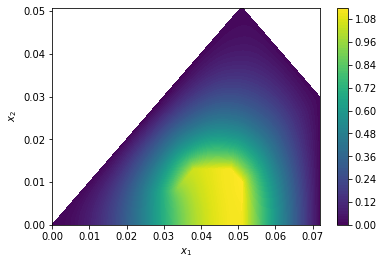

In [ ]:
param = np.array([0,0,0,0,0,0])
x,y = np.meshgrid(np.linspace(-1,1,100),np.linspace(-1,1,100))
ys = np.concatenate((x.flatten()[:,None],y.flatten()[:,None]),1)
ps = np.zeros((ys.shape[0],6))
ps = np.ones((ys.shape[0],6)) * param
xy1 = geom1(ys, ps)
xy2 = geom2(ys, ps)
xy3 = geom3(ys, ps)
xy4 = geom4(ys, ps)

u1 = model.solution1(weights, ys, ps).reshape(x.shape)
u2 = model.solution2(weights, ys, ps).reshape(x.shape)
u3 = model.solution3(weights, ys, ps).reshape(x.shape)
u4 = model.solution4(weights, ys, ps).reshape(x.shape)

# plt.figure(figsize = (20,12))
ax = plt.gca()
plt.contourf(xy1[:,0].reshape(x.shape), xy1[:,1].reshape(x.shape), u1, levels = 100, vmin = min([u1.min(),u2.min(),u3.min(),u4.min()]), vmax = max([u1.max(),u2.max(),u3.max(),u4.max()]))
plt.contourf(xy2[:,0].reshape(x.shape), xy2[:,1].reshape(x.shape), u2, levels = 100, vmin = min([u1.min(),u2.min(),u3.min(),u4.min()]), vmax = max([u1.max(),u2.max(),u3.max(),u4.max()]))
plt.contourf(xy3[:,0].reshape(x.shape), xy3[:,1].reshape(x.shape), u3, levels = 100, vmin = min([u1.min(),u2.min(),u3.min(),u4.min()]), vmax = max([u1.max(),u2.max(),u3.max(),u4.max()]))
plt.contourf(xy4[:,0].reshape(x.shape), xy4[:,1].reshape(x.shape), u4, levels = 100, vmin = min([u1.min(),u2.min(),u3.min(),u4.min()]), vmax = max([u1.max(),u2.max(),u3.max(),u4.max()]))
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('./solution_pinn.eps')

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.954e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 6.314e+00 (tol = 1.000e-10) r (rel) = 1.597e+00 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 2.376e+00 (tol = 1.000e-10) r (rel) = 6.008e-01 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 8.892e-01 (tol = 1.000e-10) r (rel) = 2.249e-01 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 3.307e-01 (tol = 1.000e-10) r (rel) = 8.363e-02 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 1.199e-01 (tol = 1.000e-10) r (rel) = 3.033e-02 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 4.022e-02 (tol = 1.000e-10) r (rel) = 1.017e-02 (tol = 1.000e-09)
  Newton iteration 7: r (abs) = 1.067e-02 (tol = 1.000e-10) r (rel) = 2.699e-03 (tol = 1.000e-09)
  Newton iteration 8: r (abs) = 1.511e-03 (tol = 1.000e-

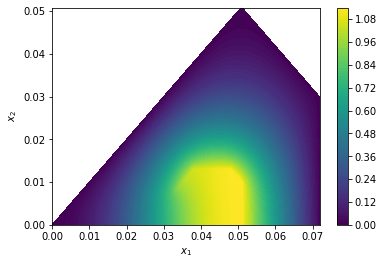

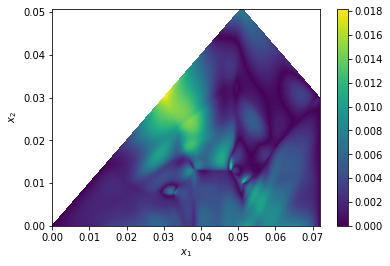

In [ ]:

fn.set_log_active(True)
fem = FEM(mu0=model.mu0,mur=model.mur,J0 = model.Itotal/surface_cu(param), k2 = model.k2, params = param, meshsize = 0.0005)



ys = np.random.rand(100000,2)*2-1
ps = np.zeros((ys.shape[0],6))
ps = np.ones((ys.shape[0],6)) * param
u1_ref = fem.call_A(np.array(xy1[:,0]), np.array(xy1[:,1])).reshape(x.shape)
u2_ref = fem.call_A(np.array(xy2[:,0]), np.array(xy2[:,1])).reshape(x.shape)
u3_ref = fem.call_A(np.array(xy3[:,0]), np.array(xy3[:,1])).reshape(x.shape)
u4_ref = fem.call_A(np.array(xy4[:,0]), np.array(xy4[:,1])).reshape(x.shape)

plt.figure()
ax = plt.gca()
plt.contourf(xy1[:,0].reshape(x.shape), xy1[:,1].reshape(x.shape), u1_ref, levels = 100, vmin = min([u1_ref.min(),u2_ref.min(),u3_ref.min(),u4_ref.min()]), vmax = max([u1_ref.max(),u2_ref.max(),u3_ref.max(),u4_ref.max()]))
plt.contourf(xy2[:,0].reshape(x.shape), xy2[:,1].reshape(x.shape), u2_ref, levels = 100, vmin = min([u1_ref.min(),u2_ref.min(),u3_ref.min(),u4_ref.min()]), vmax = max([u1_ref.max(),u2_ref.max(),u3_ref.max(),u4_ref.max()]))
plt.contourf(xy3[:,0].reshape(x.shape), xy3[:,1].reshape(x.shape), u3_ref, levels = 100, vmin = min([u1_ref.min(),u2_ref.min(),u3_ref.min(),u4_ref.min()]), vmax = max([u1_ref.max(),u2_ref.max(),u3_ref.max(),u4_ref.max()]))
plt.contourf(xy4[:,0].reshape(x.shape), xy4[:,1].reshape(x.shape), u4_ref, levels = 100, vmin = min([u1_ref.min(),u2_ref.min(),u3_ref.min(),u4_ref.min()]), vmax = max([u1_ref.max(),u2_ref.max(),u3_ref.max(),u4_ref.max()]))
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')


delta1 = np.abs(u1-u1_ref)
delta2 = np.abs(u2-u2_ref)
delta3 = np.abs(u3-u3_ref)
delta4 = np.abs(u4-u4_ref)

plt.figure()
ax = plt.gca()
plt.contourf(xy2[:,0].reshape(x.shape), xy2[:,1].reshape(x.shape), delta2, levels = 100, vmin = min([delta1.min(),delta2.min(),delta3.min(),delta4.min()]), vmax = max([delta1.max(),delta2.max(),delta3.max(),delta4.max()]))
plt.contourf(xy3[:,0].reshape(x.shape), xy3[:,1].reshape(x.shape), delta3, levels = 100, vmin = min([delta1.min(),delta2.min(),delta3.min(),delta4.min()]), vmax = max([delta1.max(),delta2.max(),delta3.max(),delta4.max()]))
plt.contourf(xy4[:,0].reshape(x.shape), xy4[:,1].reshape(x.shape), delta4, levels = 100, vmin = min([delta1.min(),delta2.min(),delta3.min(),delta4.min()]), vmax = max([delta1.max(),delta2.max(),delta3.max(),delta4.max()]))
plt.contourf(xy1[:,0].reshape(x.shape), xy1[:,1].reshape(x.shape), delta1, levels = 100, vmin = min([delta1.min(),delta2.min(),delta3.min(),delta4.min()]), vmax = max([delta1.max(),delta2.max(),delta3.max(),delta4.max()]))
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('./error_pinn.eps')

print()
print('Linf relative error',max([np.max(delta1),np.max(delta2),np.max(delta3),np.max(delta4)])/max([np.max(u1),np.max(u2),np.max(u3),np.max(u4)])*100, '%')

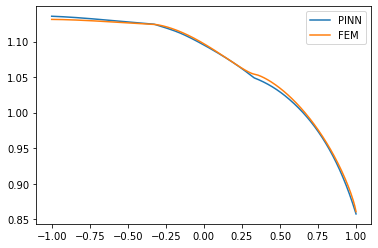

In [ ]:
plt.figure()
t = np.linspace(-1,1,1000).reshape([-1,1])
plt.plot(t.flatten(),model.solution3(weights,np.concatenate((t*0+1,t),-1), np.zeros((t.size,6))))

xy = np.array(geom3(np.concatenate((t*0+1,t),-1), np.zeros((t.size,6))))
plt.plot(t.flatten(),fem.call_A(xy[:,0],xy[:,1]))
plt.legend(['PINN', 'FEM'])

In [ ]:
xs1 = geom1(ys, ps)
xs2 = geom2(ys, ps)
xs3 = geom3(ys, ps)
xs4 = geom4(ys, ps)
omega1, _, _ = geom1.GetMetricTensors(ys,ps)
omega2, _, _ = geom2.GetMetricTensors(ys,ps)
omega3, _, _ = geom3.GetMetricTensors(ys,ps)
omega4, _, _ = geom4.GetMetricTensors(ys,ps)
ws = np.ones((ys.shape[0],))/ys.shape[0]*4

u1_ref = fem.call_A(np.array(xs1[:,0]), np.array(xs1[:,1])).flatten()
u2_ref = fem.call_A(np.array(xs2[:,0]), np.array(xs2[:,1])).flatten()
u3_ref = fem.call_A(np.array(xs3[:,0]), np.array(xs3[:,1])).flatten()
u4_ref = fem.call_A(np.array(xs4[:,0]), np.array(xs4[:,1])).flatten()

B1_ref = fem.call_B(np.array(xs1[:,0]), np.array(xs1[:,1]))
B2_ref = fem.call_B(np.array(xs2[:,0]), np.array(xs2[:,1]))
B3_ref = fem.call_B(np.array(xs3[:,0]), np.array(xs3[:,1]))
B4_ref = fem.call_B(np.array(xs4[:,0]), np.array(xs4[:,1]))

f = lambda B: np.sqrt(B[:,0]**2+B[:,1]**2)
print(np.max(f(B1_ref)),np.max(f(B2_ref)), np.max(f(B3_ref)), np.max(f(B4_ref)))

u1 = model.solution1(weights, ys, ps).flatten()
u2 = model.solution2(weights, ys, ps).flatten()
u3 = model.solution3(weights, ys, ps).flatten()
u4 = model.solution4(weights, ys, ps).flatten()

int1 = jnp.dot((u1-u1_ref)**2,omega1*ws) / jnp.dot((u1_ref)**2,omega1*ws)
int2 = jnp.dot((u2-u2_ref)**2,omega2*ws) / jnp.dot((u2_ref)**2,omega2*ws)
int3 = jnp.dot((u3-u3_ref)**2,omega3*ws) / jnp.dot((u3_ref)**2,omega3*ws)
int4 = jnp.dot((u4-u4_ref)**2,omega4*ws) / jnp.dot((u4_ref)**2,omega4*ws)

print(int1, int2, int3, int4)

L2rel = jnp.dot((u1-u1_ref)**2,omega1*ws) + jnp.dot((u2-u2_ref)**2,omega2*ws) + jnp.dot((u3-u3_ref)**2,omega3*ws) + jnp.dot((u4-u4_ref)**2,omega4*ws)
L2rel = L2rel / (jnp.dot((u1_ref)**2,omega1*ws)+jnp.dot((u2_ref)**2,omega2*ws)+jnp.dot((u3_ref)**2,omega3*ws)+jnp.dot((u4_ref)**2,omega4*ws))

print(L2rel)

143.51852902207324 87.16447675976363 85.80669813672127 142.63549721830705
0.00022493010672600678 4.733607532457241e-05 1.6495580523415018e-05 0.00010712165518064936
0.00010628404246875021


In [ ]:
print(np.mean(delta1)/np.max(u1))
print('Surface copper', np.sum(model.points['omega3']*model.points['ws3']))
print('J0 ',50/np.sum(model.points['omega3']*model.points['ws3'])*24)

0.004158933629439363
Surface copper 0.00021720792035194057
J0  5524660.417795299


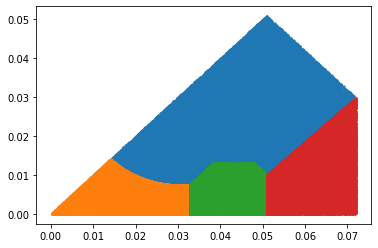

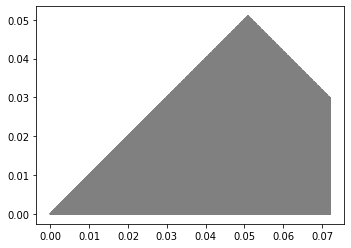

In [ ]:
plt.figure()
plt.scatter(xs1[:,0],xs1[:,1], s= 1)
plt.scatter(xs2[:,0],xs2[:,1], s= 1)
plt.scatter(xs3[:,0],xs3[:,1], s= 1)
plt.scatter(xs4[:,0],xs4[:,1], s= 1)

plt.figure()
fn.plot(fem.mesh)

In [ ]:
Np = 128

def get_ann(p):
    ps = jnp.tile(p[...,None], ys.shape[0]).T
    xs1 = geom1(ys, ps)
    xs2 = geom2(ys, ps)
    xs3 = geom3(ys, ps)
    xs4 = geom4(ys, ps)
    omega1, _, _ = geom1.GetMetricTensors(ys,ps)
    omega2, _, _ = geom2.GetMetricTensors(ys,ps)
    omega3, _, _ = geom3.GetMetricTensors(ys,ps)
    omega4, _, _ = geom4.GetMetricTensors(ys,ps)
    ws = jnp.ones((ys.shape[0],))/ys.shape[0]*4

    u1 = model.solution1(weights, ys, ps).flatten()
    u2 = model.solution2(weights, ys, ps).flatten()
    u3 = model.solution3(weights, ys, ps).flatten()
    u4 = model.solution4(weights, ys, ps).flatten()
    
    return xs1, xs2, xs3, xs4, u1, u2, u3, u4, omega1, omega2, omega3, omega4, ws
 
get_ann_compiled = jax.jit(get_ann, device = dev)

params = np.random.rand(Np,6)*2-1
L2s = []
Linfs = []
for k,ps in enumerate(params):
    
    xs1, xs2, xs3, xs4, u1, u2, u3, u4, omega1, omega2, omega3, omega4, ws = get_ann_compiled(ps)

    fem = FEM(mu0=model.mu0, mur=model.mur, J0 = model.Itotal/surface_cu(ps), params = ps, k2 = model.k2, meshsize = 0.0005)
    
    u1_ref = jnp.array(fem.call_A(np.array(xs1[:,0]), np.array(xs1[:,1])).flatten())
    u2_ref = jnp.array(fem.call_A(np.array(xs2[:,0]), np.array(xs2[:,1])).flatten())
    u3_ref = jnp.array(fem.call_A(np.array(xs3[:,0]), np.array(xs3[:,1])).flatten())
    u4_ref = jnp.array(fem.call_A(np.array(xs4[:,0]), np.array(xs4[:,1])).flatten())
    
    int1 = jnp.dot((u1-u1_ref)**2,omega1*ws) / jnp.dot((u1_ref)**2,omega1*ws)
    int2 = jnp.dot((u2-u2_ref)**2,omega2*ws) / jnp.dot((u2_ref)**2,omega2*ws)
    int3 = jnp.dot((u3-u3_ref)**2,omega3*ws) / jnp.dot((u3_ref)**2,omega3*ws)
    int4 = jnp.dot((u4-u4_ref)**2,omega4*ws) / jnp.dot((u4_ref)**2,omega4*ws)

    

    L2rel = jnp.dot((u1-u1_ref)**2,omega1*ws) + jnp.dot((u2-u2_ref)**2,omega2*ws) + jnp.dot((u3-u3_ref)**2,omega3*ws) + jnp.dot((u4-u4_ref)**2,omega4*ws)
    L2rel = L2rel / (jnp.dot((u1_ref)**2,omega1*ws)+jnp.dot((u2_ref)**2,omega2*ws)+jnp.dot((u3_ref)**2,omega3*ws)+jnp.dot((u4_ref)**2,omega4*ws))
    Linf = max([np.max(u1-u1_ref),np.max(u2-u2_ref),np.max(u3-u3_ref),np.max(u4-u4_ref)])/max([np.max(u1_ref),np.max(u2_ref),np.max(u3_ref),np.max(u4_ref)])
    Linfs.append(Linf)
    
    print()
    print(int1, int2, int3, int4)
    print('Step:',k+1, ' parameter:',ps)
    print("L2 relative:",L2rel, 'Linf relative:', Linf*100,' %')
    
    L2s.append(L2rel)
    
print()
print()
print('Mean L2 %e, max L2 %e'%(np.mean(L2s), np.max(L2s)))
print('Mean Linf %f %% max Linf %f %%'%(np.mean(Linfs)*100, np.max(Linfs)*100))
print('Number of DoFs %d'%(w0.shape))

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.040e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.069e+00 (tol = 1.000e-10) r (rel) = 2.645e-01 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 4.025e-01 (tol = 1.000e-10) r (rel) = 9.963e-02 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.491e-01 (tol = 1.000e-10) r (rel) = 3.691e-02 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 5.311e-02 (tol = 1.000e-10) r (rel) = 1.314e-02 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 1.672e-02 (tol = 1.000e-10) r (rel) = 4.139e-03 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 3.734e-03 (tol = 1.000e-10) r (rel) = 9.242e-04 (tol = 1.000e-09)
  Newton iteration 7: r (abs) = 3.421e-04 (tol = 1.000e-10) r (rel) = 8.468e-05 (tol = 1.000e-09)
  Newton iteration 8: r (abs) = 3.684e-06 (tol = 1.000e-